# YELP Recommendation System

In [1]:
from fastai.collab import *
from time import time

In [2]:
path = Path('.')
# path.ls()

In [3]:
train_df = pd.read_csv(path/'yelp_train.csv')
test_df = pd.read_csv(path/'yelp_val.csv')
# print(train_df.columns)
train_df["stars"]= train_df["stars"].astype(float)
test_df["stars"]= test_df["stars"].astype(float)
train_df.head()

,user_id,business_id,stars
0,vxR_YV0atFxIxfOnF9uHjQ,gTw6PENNGl68ZPUpYWP50A,5.0
1,o0p-iTC5yTBV5Yab_7es4g,iAuOpYDfOTuzQ6OPpEiGwA,4.0
2,-qj9ouN0bzMXz1vfEslG-A,5j7BnXXvlS69uLVHrY9Upw,2.0
3,E43QxgV87Ij6KxMCHcijKw,jUYp798M93Mpcjys_TTgsQ,5.0
4,T13IBpJITI32a1k41rc-tg,3MntE_HWbNNoyiLGxywjYA,5.0


In [4]:
data = CollabDataBunch.from_df(ratings=train_df, seed=5, valid_pct=0.1,user_name='user_id', 
                               item_name='business_id', rating_name='stars', test=test_df, bs=len(test_df))

In [5]:
# data.show_batch()

In [6]:
train_df.stars.min(), train_df.stars.max()

(1.0, 5.0)

In [7]:
def my_rmse(x,y):
    return math.sqrt(((x-y)**2).mean())

In [8]:
wd=1e-4 
n_epochs=20
n_factors=50
lr=4e-3

## EmbeddingDotBias Model

In [9]:
learn = collab_learner(data, n_factors=n_factors, y_range=(1, 5.5), wd=wd, model_dir="./model/", path=path)

In [10]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Embedding            [50]                 563,550    True      
______________________________________________________________________
Embedding            [50]                 1,231,000  True      
______________________________________________________________________
Embedding            [1]                  11,271     True      
______________________________________________________________________
Embedding            [1]                  24,620     True      
______________________________________________________________________

Total params: 1,830,441
Total trainable params: 1,830,441
Total non-trainable params: 0



In [11]:
# learn.lr_find()
# learn.lr_find2()
# learn.recorder.plot()

In [12]:
learn.fit(lr=lr, epochs=n_epochs, wd=wd)

epoch,train_loss,valid_loss,time
0,1.515467,1.497104,02:26
1,1.504048,1.480332,02:30
2,1.495000,1.463931,02:23
3,1.483386,1.447794,02:24
4,1.472758,1.431834,02:27
5,1.460652,1.415905,02:23
6,1.448070,1.399920,02:26
7,1.434212,1.383805,02:27
8,1.419679,1.367473,02:25
9,1.404737,1.350864,02:10


In [13]:
learn.save('yelp-dot-5.pkl')

In [14]:
(users,items), ratings = next(iter(data.test_dl))
preds = learn.model(users, items)

start_time = time()

test_time = time() - start_time
scores = pd.DataFrame(
    {"user_id": test_df["user_id"], "business_id": test_df["business_id"], "rating": preds}
)
scores = scores.sort_values(["user_id", "rating"], ascending=[True, False])

print("Took {} seconds for {} predictions.".format(test_time, len(test_df)))

Took 0.0 seconds for 142044 predictions.


In [15]:
y = test_df["stars"]
y1 = scores["rating"]

In [16]:
# type(y), type(y1)

In [17]:
result =  math.sqrt(((y1-y)**2).mean())
print("RMSE: ", result)

RMSE:  1.0856660956298938


## Interpretation

In [18]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")
learn.load('yelp-dot-1');

In [19]:
businesses = {}
businesses =  pd.read_json(path/"business.json", orient='columns',lines=True)
business_df =  pd.DataFrame.from_dict(businesses)
business_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",MontrÃ©al,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB


In [20]:
g = train_df.groupby('business_id')['stars'].count()
top_business = g.sort_values(ascending=False).index.values[:1000]
top_business = top_business.astype(str)
top_business[:10]

array(['4JNXUYY8wbaaDmk3BPzlWw', 'FaHADZARwnY4yvlvpnsfGA', 'K7lWdNUhCbcnEvI0NhGewg', 'RESDUcs7fIiihp38-d6_6g',
       '7sPNbCx7vGAaH7SbNPZ6oA', 'iCQpiavjjPzJ5_3gPD5Ebg', 'r_BrIgzYcwo1NAuG9dLbpg', 'eoHdUeQDNgQ6WYEnP2aiRw',
       'DkYS3arLOhA8si5uUEmHOw', 'UPIYuRaZvknINOd1w8kqRQ'], dtype='<U22')

In [21]:
top_businesses_with_name = []
for business in top_business:
    top_businesses_with_name.append(business_df[(business_df['business_id']==business)]['name'].iloc[0])
top_businesses_with_name = np.array(top_businesses_with_name)
top_businesses_with_name

array(['Mon Ami Gabi', 'McCarran International Airport', 'Wicked Spoon', 'Bacchanal Buffet', ..., 'Fugo Desserts',
       "Nicky's Thai Kitchen", 'Lamesa Filipino Kitchen', "Rachel's Kitchen"], dtype='<U57')

## Restaurant Bias

In [22]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(11271, 40)
  (i_weight): Embedding(24620, 40)
  (u_bias): Embedding(11271, 1)
  (i_bias): Embedding(24620, 1)
)

In [23]:
business_bias = learn.bias(top_business, is_item=True)

In [24]:
mean_ratings = train_df.groupby('business_id')['stars'].mean()
business_ratings = [(b, top_businesses_with_name[i], mean_ratings.loc[tb]) for i, (tb, b) in enumerate(zip(top_business, business_bias))]

In [25]:
item0 = lambda o:o[0]

In [26]:
sorted(business_ratings, key=item0)[:15]

[(tensor(-0.0182), 'Bellwoods Brewery', 3.897727272727273),
 (tensor(-0.0182), 'Sienna Mercato', 3.984848484848485),
 (tensor(-0.0181), 'Primanti Bros', 3.5060240963855422),
 (tensor(-0.0180), 'KINKA IZAKAYA BLOOR', 4.080357142857143),
 (tensor(-0.0179), 'The Chandelier', 4.25748502994012),
 (tensor(-0.0176), 'Regal Cinemas Red Rock 16 & IMAX', 3.8598130841121496),
 (tensor(-0.0176), 'The Oyster Bar', 4.359375),
 (tensor(-0.0174), 'Aloha Specialties', 3.967032967032967),
 (tensor(-0.0170), 'The Fat Greek', 4.0125),
 (tensor(-0.0166), 'Geisha House Steak & Sushi', 3.7857142857142856),
 (tensor(-0.0165), 'Islands Restaurant', 3.4383561643835616),
 (tensor(-0.0164), 'Sidestreet Pho and Grill', 4.168674698795181),
 (tensor(-0.0164), 'Public House', 3.8550724637681157),
 (tensor(-0.0162), 'Hash House A Go Go', 3.0985915492957745),
 (tensor(-0.0161), 'Shake Shack', 3.735042735042735)]

In [27]:
sorted(business_ratings, key=item0, reverse=True)[:15]

[(tensor(0.0214), 'Viet Bistro', 3.4523809523809526),
 (tensor(0.0214), 'Viet Noodle Bar', 4.2846153846153845),
 (tensor(0.0209), 'Beerbistro', 3.875),
 (tensor(0.0208), 'China Poblano', 3.267716535433071),
 (tensor(0.0205), 'MerÃ¡ki Greek Grill', 4.741176470588235),
 (tensor(0.0204), 'Burrito Boyz', 3.9027777777777777),
 (tensor(0.0202), 'Nadege', 4.116071428571429),
 (tensor(0.0201), 'Swish Shabu Shabu', 3.610526315789474),
 (tensor(0.0197), 'West Side Market', 4.627118644067797),
 (tensor(0.0197), 'Black Camel', 4.2105263157894735),
 (tensor(0.0196), 'Kuma Snow Cream', 3.4358974358974357),
 (tensor(0.0196),
  'Paymons Mediterranean Cafe & Hookah Lounge',
  3.6666666666666665),
 (tensor(0.0196), 'Barroco', 4.506666666666667),
 (tensor(0.0192), 'Babystacks Cafe', 3.770642201834862),
 (tensor(0.0191), 'Whole Foods Market', 3.9894736842105263)]

In [28]:
business_w = learn.weight(top_business, is_item=True)
business_w.shape

torch.Size([1000, 40])

In [29]:
business_pca = business_w.pca(3)
business_pca.shape

torch.Size([1000, 3])

In [30]:
fac0,fac1,fac2 = business_pca.t()
business_comp = [(f, i) for f,i in zip(fac0, top_businesses_with_name)]

In [31]:
sorted(business_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.0336), 'Mill Street Brew Pub'),
 (tensor(0.0319), 'Ichiza'),
 (tensor(0.0307), 'Jenni Pho'),
 (tensor(0.0296), 'Mac Shack Spring Valley'),
 (tensor(0.0277), "Fran's Restaurant"),
 (tensor(0.0274), 'Nothing Bundt Cakes'),
 (tensor(0.0251), 'Coca-Cola Store Las Vegas'),
 (tensor(0.0246), 'Cornish Pasty'),
 (tensor(0.0246), 'Pho Aimie'),
 (tensor(0.0242), "Tommy's Restaurant")]

In [32]:
sorted(business_comp, key=itemgetter(0))[:10]

[(tensor(-0.0305), 'Bread and Butter'),
 (tensor(-0.0275), 'Art of Flavors'),
 (tensor(-0.0271), 'Donut Bar'),
 (tensor(-0.0260), 'Tryst Nightclub'),
 (tensor(-0.0259), 'Pizzeria Libretto'),
 (tensor(-0.0253), 'Galaxy Cannery Theatre'),
 (tensor(-0.0251), 'Fat Choy'),
 (tensor(-0.0251), 'Tupelo Honey'),
 (tensor(-0.0243), 'SUSHISAMBA - Las Vegas'),
 (tensor(-0.0243), 'Byblos')]

In [33]:
business_comp = [(f, i) for f,i in zip(fac1, top_businesses_with_name)]

In [34]:
sorted(business_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.0345), 'Restoran Malaysia'),
 (tensor(0.0261), 'Elephant Bar Restaurant'),
 (tensor(0.0260), 'Mill Street Brew Pub'),
 (tensor(0.0254), 'Brew Tea Bar'),
 (tensor(0.0253), "Ronald's Donuts"),
 (tensor(0.0252), 'Pink Box Doughnuts'),
 (tensor(0.0249), 'CREAM'),
 (tensor(0.0247), 'HofbrÃ¤uhaus Las Vegas'),
 (tensor(0.0242), 'Burgatory'),
 (tensor(0.0238), 'To See Roll')]

In [35]:
sorted(business_comp, key=itemgetter(0))[:10]

[(tensor(-0.0313), 'Planet Hollywood Las Vegas Resort & Casino'),
 (tensor(-0.0281), 'Pampas Churrascaria Brazilian Grille'),
 (tensor(-0.0274), 'Dragon Legend'),
 (tensor(-0.0265), 'Viva Zapatas Mexican Restaurant & Cantina'),
 (tensor(-0.0260), 'South Point Hotel, Casino & Spa'),
 (tensor(-0.0251), 'Raijin Ramen'),
 (tensor(-0.0249), "Naked Fish's Sushi & Grill"),
 (tensor(-0.0247), 'Soul Gastrolounge'),
 (tensor(-0.0246), "Mount Everest India's Cuisine"),
 (tensor(-0.0246), "Du-Par's")]

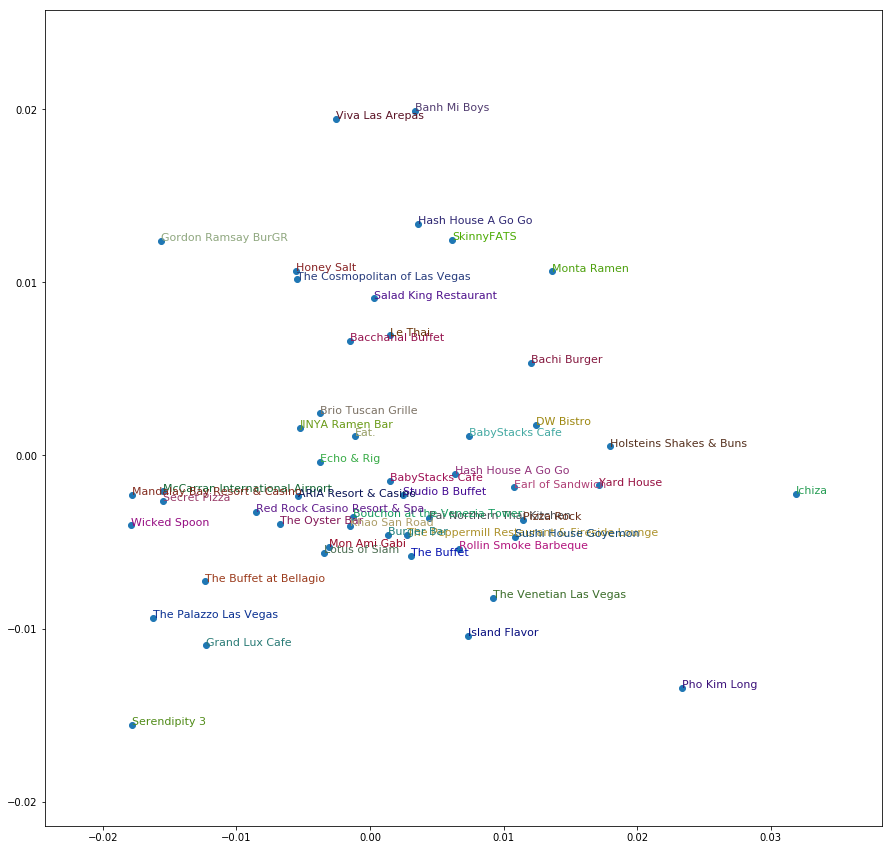

In [36]:
idxs = np.random.choice(len(top_businesses_with_name), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_businesses_with_name[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()